In [1]:
from normalization import normalize_corpus, parse_document
from utils import build_feature_matrix, low_rank_svd
import numpy as np

toy_text = """
Elephants are large mammals of the family Elephantidae 
and the order Proboscidea. Two species are traditionally recognised, 
the African elephant and the Asian elephant. Elephants are scattered 
throughout sub-Saharan Africa, South Asia, and Southeast Asia. Male 
African elephants are the largest extant terrestrial animals. All 
elephants have a long trunk used for many purposes, 
particularly breathing, lifting water and grasping objects. Their 
incisors grow into tusks, which can serve as weapons and as tools 
for moving objects and digging. Elephants' large ear flaps help 
to control their body temperature. Their pillar-like legs can 
carry their great weight. African elephants have larger ears 
and concave backs while Asian elephants have smaller ears 
and convex or level backs.  
"""

In [2]:
from gensim.summarization import summarize, keywords

def text_summarization_gensim(text, summary_ratio=0.5):
    
    summary = summarize(text, split=True, ratio=summary_ratio)
    for sentence in summary:
        print(sentence)

docs = parse_document(toy_text)
text = ' '.join(docs)
text_summarization_gensim(text, summary_ratio=0.4)


    
sentences = parse_document(toy_text)
norm_sentences = normalize_corpus(sentences,lemmatize=False) 

total_sentences = len(norm_sentences)
print('Total Sentences in Document:', total_sentences)   

Elephants are large mammals of the family Elephantidae  and the order Proboscidea.
Two species are traditionally recognised,  the African elephant and the Asian elephant.
African elephants have larger ears  and concave backs while Asian elephants have smaller ears  and convex or level backs.
Total Sentences in Document: 9


In [3]:
num_sentences = 3
num_topics = 2

vec, dt_matrix = build_feature_matrix(sentences, 
                                      feature_type='frequency')

td_matrix = dt_matrix.transpose()
td_matrix = td_matrix.multiply(td_matrix > 0)

u, s, vt = low_rank_svd(td_matrix, singular_count=num_topics)  
                                         
sv_threshold = 0.5
min_sigma_value = max(s) * sv_threshold
s[s < min_sigma_value] = 0

salience_scores = np.sqrt(np.dot(np.square(s), np.square(vt)))
print(np.round(salience_scores, 2))

[2.02 2.07 1.53 1.4  2.1  4.48 0.7  1.2  4.65]


In [4]:
top_sentence_indices = salience_scores.argsort()[-num_sentences:][::-1]
top_sentence_indices.sort()
print(top_sentence_indices)

[4 5 8]


In [5]:
for index in top_sentence_indices:
    print(sentences[index])

All  elephants have a long trunk used for many purposes,  particularly breathing, lifting water and grasping objects.
Their  incisors grow into tusks, which can serve as weapons and as tools  for moving objects and digging.
African elephants have larger ears  and concave backs while Asian elephants have smaller ears  and convex or level backs.


In [8]:
def lsa_text_summarizer(documents, num_sentences=2,
                        num_topics=2, feature_type='frequency',
                        sv_threshold=0.5):
                            
    vec, dt_matrix = build_feature_matrix(documents, 
                                          feature_type=feature_type)

    td_matrix = dt_matrix.transpose()
    td_matrix = td_matrix.multiply(td_matrix > 0)

    u, s, vt = low_rank_svd(td_matrix, singular_count=num_topics)  
    min_sigma_value = max(s) * sv_threshold
    s[s < min_sigma_value] = 0
    
    salience_scores = np.sqrt(np.dot(np.square(s), np.square(vt)))
    top_sentence_indices = salience_scores.argsort()[-num_sentences:][::-1]
    top_sentence_indices.sort()
    
    for index in top_sentence_indices:
        print(sentences[index])

[[1.   0.   0.03 0.05 0.03 0.   0.15 0.   0.06]
 [0.   1.   0.   0.07 0.   0.   0.   0.   0.11]
 [0.03 0.   1.   0.03 0.02 0.   0.03 0.   0.04]
 [0.05 0.07 0.03 1.   0.03 0.   0.04 0.   0.11]
 [0.03 0.   0.02 0.03 1.   0.07 0.03 0.   0.04]
 [0.   0.   0.   0.   0.07 1.   0.   0.   0.  ]
 [0.15 0.   0.03 0.04 0.03 0.   1.   0.   0.05]
 [0.   0.   0.   0.   0.   0.   0.   1.   0.  ]
 [0.06 0.11 0.04 0.11 0.04 0.   0.05 0.   1.  ]]
[0, 3, 8]
Elephants are large mammals of the family Elephantidae  and the order Proboscidea.
Male  African elephants are the largest extant terrestrial animals.
African elephants have larger ears  and concave backs while Asian elephants have smaller ears  and convex or level backs.


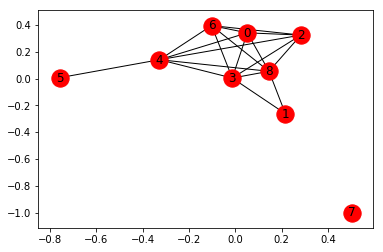

In [14]:
import networkx

num_sentences = 3
vec, dt_matrix = build_feature_matrix(norm_sentences, 
                                      feature_type='tfidf')
similarity_matrix = (dt_matrix * dt_matrix.T)
print(np.round(similarity_matrix.todense(), 2))

similarity_graph = networkx.from_scipy_sparse_matrix(similarity_matrix)

networkx.draw_networkx(similarity_graph)

scores = networkx.pagerank(similarity_graph)

ranked_sentences = sorted(((score, index) 
                            for index, score 
                            in scores.items()), 
                          reverse=True)
ranked_sentences

top_sentence_indices = [ranked_sentences[index][1] 
                        for index in range(num_sentences)]
top_sentence_indices.sort()
print(top_sentence_indices)

for index in top_sentence_indices:
    print(sentences[index])
    


In [18]:
def textrank_text_summarizer(documents, num_sentences=2,
                             feature_type='frequency'):
    
    vec, dt_matrix = build_feature_matrix(norm_sentences, 
                                      feature_type='tfidf')
    similarity_matrix = (dt_matrix * dt_matrix.T)
        
    similarity_graph = networkx.from_scipy_sparse_matrix(similarity_matrix)
    scores = networkx.pagerank(similarity_graph)   
    
    ranked_sentences = sorted(((score, index) 
                                for index, score 
                                in scores.items()), 
                              reverse=True)

    top_sentence_indices = [ranked_sentences[index][1] 
                            for index in range(num_sentences)]
    top_sentence_indices.sort()
    
    for index in top_sentence_indices:
        print(sentences[index])      
        

DOCUMENT = """
The Elder Scrolls V: Skyrim is an open world action role-playing video game 
developed by Bethesda Game Studios and published by Bethesda Softworks. 
It is the fifth installment in The Elder Scrolls series, following 
The Elder Scrolls IV: Oblivion. Skyrim's main story revolves around 
the player character and their effort to defeat Alduin the World-Eater, 
a dragon who is prophesied to destroy the world. 
The game is set two hundred years after the events of Oblivion 
and takes place in the fictional province of Skyrim. The player completes quests 
and develops the character by improving skills. 
Skyrim continues the open world tradition of its predecessors by allowing the 
player to travel anywhere in the game world at any time, and to 
ignore or postpone the main storyline indefinitely. The player may freely roam 
over the land of Skyrim, which is an open world environment consisting 
of wilderness expanses, dungeons, cities, towns, fortresses and villages. 
Players may navigate the game world more quickly by riding horses, 
or by utilizing a fast-travel system which allows them to warp to previously 
Players have the option to develop their character. At the beginning of the game, 
players create their character by selecting one of several races, 
including humans, orcs, elves and anthropomorphic cat or lizard-like creatures, 
and then customizing their character's appearance.discovered locations. Over the 
course of the game, players improve their character's skills, which are numerical 
representations of their ability in certain areas. There are eighteen skills 
divided evenly among the three schools of combat, magic, and stealth. 
Skyrim is the first entry in The Elder Scrolls to include Dragons in the game's 
wilderness. Like other creatures, Dragons are generated randomly in the world 
and will engage in combat. 
"""


sentences = parse_document(DOCUMENT)
norm_sentences = normalize_corpus(sentences,lemmatize=True) 
print("Total Sentences:", len(norm_sentences)) 



Total Sentences: 13


In [19]:
lsa_text_summarizer(norm_sentences, num_sentences=3,
                    num_topics=5, feature_type='frequency',
                    sv_threshold=0.5)  

The Elder Scrolls V: Skyrim is an open world action role-playing video game  developed by Bethesda Game Studios and published by Bethesda Softworks.
Players may navigate the game world more quickly by riding horses,  or by utilizing a fast-travel system which allows them to warp to previously  Players have the option to develop their character.
At the beginning of the game,  players create their character by selecting one of several races,  including humans, orcs, elves and anthropomorphic cat or lizard-like creatures,  and then customizing their character's appearance.discovered locations.


In [20]:
textrank_text_summarizer(norm_sentences, num_sentences=3,
                         feature_type='tfidf')       

The Elder Scrolls V: Skyrim is an open world action role-playing video game  developed by Bethesda Game Studios and published by Bethesda Softworks.
Players may navigate the game world more quickly by riding horses,  or by utilizing a fast-travel system which allows them to warp to previously  Players have the option to develop their character.
Skyrim is the first entry in The Elder Scrolls to include Dragons in the game's  wilderness.
